In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install opensmile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.5 MB 8.2 MB/s 
     |████████████████████████████████| 48 kB 5.0 MB/s 
     |████████████████████████████████| 635 kB 68.0 MB/s 
     |████████████████████████████████| 167 kB 75.8 MB/s 
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=169061 sha256=33ddd95d0d5e00c78dc222c8aa7393a8b3b5a5033abf9c3d8621afdede81898c
  Stored in directory: /root/.cache/pip/wheels/47/60/19/6d020fc92138ed1b113a18271e83ea4b5525fe770cb45b9a2e
Successfully built iso-639


In [36]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchsummary import summary
import torchaudio.transforms as T
import torchaudio
import pickle
import matplotlib.pyplot as plt
import librosa

from tqdm import tqdm_notebook
import os
import sys
from pathlib import Path
from datetime import datetime
import random
from random import randint

import gc
import wandb
# import opensmile

# Data gaining

In [6]:
!unzip -q /content/gdrive/MyDrive/data_2.zip

In [7]:
ROOT = "data_2/"
ALL_SOUNDS = list(Path(ROOT).glob("**/*.wav"))
ALL_SOUNDS = list(filter(lambda x: not x.name.startswith("."), ALL_SOUNDS))
print("Number of sounds:", len(ALL_SOUNDS))

Number of sounds: 97377


In [8]:
data_list = []
with open('/content/gdrive/MyDrive/data_base_2.pickle', 'rb') as fh:
  data_list = pickle.load(fh)

In [9]:
len(data_list)

97377

In [10]:
random.seed(123456)
np.random.seed(123456)
torch.manual_seed(123456)

In [11]:
x = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4]])
y = torch.unsqueeze(x, 1)
x.size(), y.size(), torch.squeeze(y, -2).size()

(torch.Size([2, 4]), torch.Size([2, 1, 4]), torch.Size([2, 4]))

In [12]:
X, sr = librosa.load(f"{'/content/data_2'}/{'1779aa8fa7c65971e5538dab28acc589_SNR_3'}.wav", sr=8000)
torch.unsqueeze(torch.from_numpy(X.astype('float32')), 0)

tensor([[ 0.1457, -0.0621,  0.0548,  ..., -0.0608,  0.1480,  0.0121]])

# Data preporation

In [13]:
class SoundDataset_feature_map(torch.utils.data.Dataset):
    def __init__(self, rootdir, subset, transform=None):
        self.transform = transform
        self.rootdir = rootdir
        self.subset = subset
        self.mfcc_transform = T.MFCC(
            sample_rate=8000,
            n_mfcc=256,
            melkwargs={
                "n_fft": 2048,
                "n_mels": 256,
                "hop_length": 512,
                "mel_scale": "htk",
            },
        )

    def __getitem__(self, index):
        xname, y = self.subset[index].values()
        signal, sr = librosa.load(f"{self.rootdir}/{xname}.wav", sr=8000)
        if self.transform:
            X = torch.unsqueeze(self.mfcc_transform(torch.from_numpy(signal)), 0)
            y = torch.unsqueeze(self.transform(y.astype('float32')), 0)
            signal = torch.unsqueeze(self.transform(signal.astype('float32')), 0)
        return xname, X, y, signal

    def __len__(self):
        return len(self.subset)

class ToTensor(object):
    def __call__(self, sample):
        return torch.from_numpy(sample)

class SoundDataset_baseline(torch.utils.data.Dataset):
    def __init__(self, rootdir, subset, transform=None):
        self.transform = transform
        self.rootdir = rootdir
        self.subset = subset

    def __getitem__(self, index):
        xname, y = self.subset[index].values()
        X, _ = librosa.load(f"{self.rootdir}/{xname}.wav", sr=8000)
        if self.transform:
            X = torch.unsqueeze(self.transform(X.astype('float32')), 0)
            y = torch.unsqueeze(self.transform(y.astype('float32')), 0)
        return xname, X, y, -1

    def __len__(self):
        return len(self.subset)

class ToTensor(object):
    def __call__(self, sample):
        return torch.from_numpy(sample)

In [14]:
def find_words_edges(marks):
    lst = np.array([[0, 0]])
    flag = False
    temp = []
    for i in np.arange(len(marks)):
        if marks[i] == 1 and flag == False:
            temp.append(i / 10000)
            flag = True
        if marks[i] == 0 and flag == True:
            temp.append(i / 10000)
            flag = False
            lst = np.append(lst, [temp], axis=0)
            temp = []
    return lst[1:]

In [15]:
def plot_signal_spectrogram(signal, specgram, title=None, ylabel="freq_bin"):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    inp = torch.squeeze(signal).cpu().numpy()
    time = np.linspace(0., inp.size/8000, inp.size)
    ax1.set_title(title)
    ax1.plot(time, inp)
    ax2.set_title("Spectrogram (db)")
    ax2.set_ylabel(ylabel)
    ax2.set_xlabel("frame")
    im = ax2.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")

    fig.colorbar(im, ax=ax2)

    plt.show()

In [16]:
def sound_show(inp, title=None, marks_true=None, marks_pred=None):
    inp = torch.squeeze(inp).cpu().numpy()
    time = np.linspace(0., inp.size/8000, inp.size)
    height = 1.5*np.max(inp)
    plt.figure(figsize=(16, 8))
    signal = plt.plot(time, inp)
    plt.title(title)
    try:
        if marks_pred is not None or marks_true is not None:
            marks_true = torch.squeeze(marks_true).cpu().numpy()
            marks_pred = torch.squeeze(marks_pred.detach()).cpu().numpy()
            words_grid_true = find_words_edges(marks_true)
            words_grid_pred = find_words_edges(marks_pred)

            for edges in words_grid_pred:
                edges_pred_0 = plt.vlines(edges[0], -height, height, colors='green', linewidth=2)
                edges_pred_1 = plt.vlines(edges[1], -height, height, colors='green', linewidth=2)

            for edges in words_grid_true:
                edges_true = []
                edges_true_0 = plt.vlines(edges[0], -height, height, colors='red', linewidth=2, linestyles='dashed')
                edges_true_1 = plt.vlines(edges[1], -height, height, colors='red', linewidth=2, linestyles='dashed')
            plt.legend([signal, edges_pred_0, edges_true_0], ['Signal', 'Predicted edges', 'True edges'])
    except UnboundLocalError:
        pass
    plt.show()

In [17]:
path_data = '/content/data_2'

end_idx_tv = 87000
train_valid_subset = data_list[:end_idx_tv]
test_subset = data_list[end_idx_tv:]

lengths = [int(len(train_valid_subset) * 0.9), int(len(train_valid_subset) * 0.1)]
train_subset, valid_subset = torch.utils.data.random_split(train_valid_subset, lengths)
print(train_subset[0])

{'name': '7a263d8418b34994ad76a38298347100_SNR_3', 'marks': array([0, 0, 0, ..., 0, 0, 0], dtype=int8)}


**Baseline dataset**

{'train': 78300, 'valid': 8700, 'test': 10377}


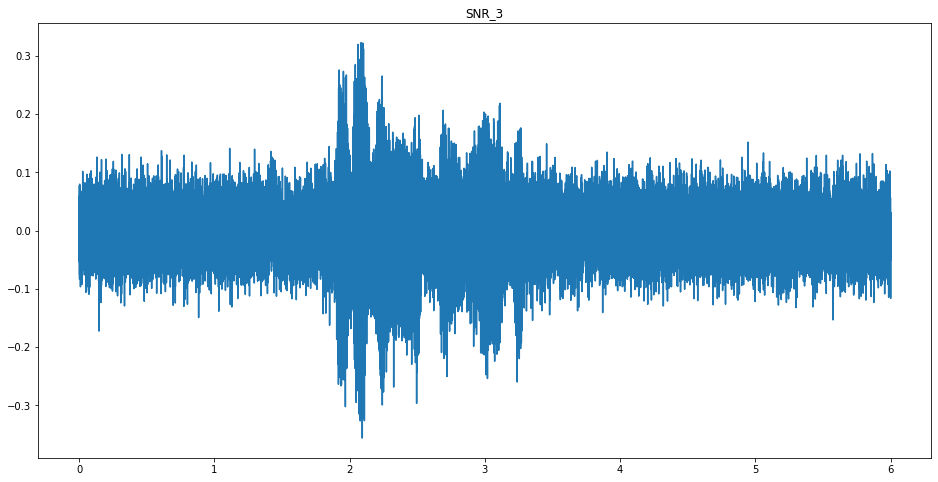

In [18]:
transform_baseline = transforms.Compose([ToTensor()])
data_set_baseline = {
            'train': SoundDataset_baseline(rootdir=path_data, subset=train_subset, transform=transform_baseline),
            'valid': SoundDataset_baseline(rootdir=path_data, subset=valid_subset, transform=transform_baseline),
            'test': SoundDataset_baseline(rootdir=path_data, subset=test_subset, transform=transform_baseline)
           }

batch_size = 512
loaders_baseline = {
            'train': torch.utils.data.DataLoader(data_set_baseline['train'], batch_size=batch_size, shuffle=True),
            'valid': torch.utils.data.DataLoader(data_set_baseline['valid'], batch_size=batch_size, shuffle=True),
            'test': torch.utils.data.DataLoader(data_set_baseline['test'], batch_size=1, shuffle=False)
          }

dataset_sizes = {x: len(data_set_baseline[x]) for x in ['train', 'valid', 'test']}
xname, X, y, _ = data_set_baseline['train'][0]
print(dataset_sizes)
sound_show(X, title=f'SNR_{xname.split("_SNR_")[1]}', marks_true=None, marks_pred=None)

**Feature map dataset**

{'train': 78300, 'valid': 8700, 'test': 10377}


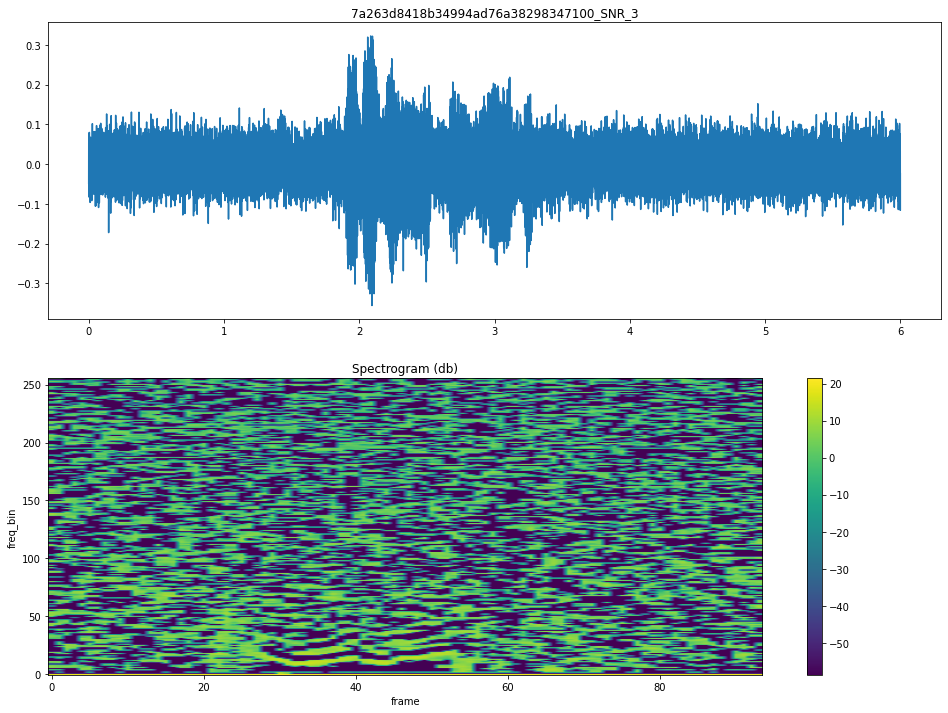

In [19]:
transform_baseline = transforms.Compose([ToTensor()])
data_set_feature_map = {
            'train': SoundDataset_feature_map(rootdir=path_data, subset=train_subset, transform=transform_baseline),
            'valid': SoundDataset_feature_map(rootdir=path_data, subset=valid_subset, transform=transform_baseline),
            'test': SoundDataset_feature_map(rootdir=path_data, subset=test_subset, transform=transform_baseline)
           }

batch_size = 512
loaders_feature_map = {
            'train': torch.utils.data.DataLoader(data_set_feature_map['train'], batch_size=batch_size, shuffle=True),
            'valid': torch.utils.data.DataLoader(data_set_feature_map['valid'], batch_size=batch_size, shuffle=True),
            'test': torch.utils.data.DataLoader(data_set_feature_map['test'], batch_size=1, shuffle=False)
          }

dataset_sizes = {x: len(data_set_baseline[x]) for x in ['train', 'valid', 'test']}
xname, X, y, signal = data_set_feature_map['train'][0]
print(dataset_sizes)
# sound_show(signal, title=f'SNR_{xname.split("_SNR_")[1]}', marks_true=None, marks_pred=None)
plot_signal_spectrogram(signal, X[0], title=xname)
print(X[0].size())

# Models

In [20]:
class ConvConvT1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=101,
                      stride=20, padding=50),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=64),

            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=101,
                      stride=20, padding=50),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=128),

            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=101,
                      stride=20, padding=50),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=256),
        )

        self.convT_layers = nn.Sequential(
            nn.ConvTranspose1d(in_channels=256,
                               out_channels=128,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=128),
            nn.ConvTranspose1d(in_channels=128,
                               out_channels=64,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=64),
            nn.ConvTranspose1d(in_channels=64,
                               out_channels=1,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
        )

    def forward(self, x):
        return self.convT_layers(self.conv_layers(x))

class ConvConvT2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=(20, 5),
                      stride=(10, 2),
                      padding=(10, 2)),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(2, 2),
                      padding=(1, 1)),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=128),
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(13, 3),
                      stride=(1, 2),
                      padding=(0, 1)),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm2d(num_features=256),
        )

        self.convT_layers = nn.Sequential(
            nn.ConvTranspose1d(in_channels=256,
                               out_channels=128,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=128),
            nn.ConvTranspose1d(in_channels=128,
                               out_channels=64,
                               kernel_size=101,
                               stride=20,
                               padding=50,
                               output_padding=19),
            nn.Dropout(p=0.7),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(num_features=64),
            nn.ConvTranspose1d(in_channels=64,
                               out_channels=1,
                               kernel_size=101,
                               stride=10,
                               padding=50,
                               output_padding=9),
        )

    def forward(self, x):
        return self.convT_layers(torch.squeeze(self.conv_layers(x), -2))

torch.Size([256, 94])


# Model prepare

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [22]:
def init_weights(m):
    if type(m) in (nn.Conv1d, nn.Conv2d, nn.ConvTranspose1d):
        nn.init.kaiming_uniform_(m.weight, a=0.2, nonlinearity='leaky_relu')
    else:
        print('Not setting weights for type {}'.format(type(m)))

In [23]:
def save(path):
    torch.save({
        'loss': loss,
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss_epochs': train_losses,
        'valid_loss_epochs': valid_losses,
        'train_metrics': train_metrics,
        'valid_metrics': valid_metrics
    }, path)

In [24]:
def binary_acc(y_pred, y_test):
    correct_results_sum = (y_pred == y_test).sum().float()
    print(torch.unique(y_pred))
    acc = correct_results_sum/(y_test.shape[0]*y_test.shape[2])
    # acc = torch.round(acc * 100)
    
    return acc

In [25]:
epochs = 10

In [26]:
def init_model(path=None, type='ConvT1D'):
    max_lr = 0.05
    div_factor = 250
    weight_decay = 0.0005

    loss = nn.BCEWithLogitsLoss(pos_weight=torch.ones(48000, dtype=torch.float16).cuda() * 3).cuda()

    if type == 'ConvT1D':
        model = ConvConvT1D().cuda()
        optim = torch.optim.AdamW(model.parameters(), lr=max_lr / div_factor,
                                    weight_decay=weight_decay, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=max_lr,
                                steps_per_epoch=len(loaders_baseline['train']),
                                epochs=epochs, div_factor=div_factor)
    elif type == 'ConvT2D':
        model = ConvConvT2D().cuda()
        optim = torch.optim.AdamW(model.parameters(), lr=max_lr / div_factor,
                                    weight_decay=weight_decay, amsgrad=True)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=max_lr,
                                steps_per_epoch=len(loaders_feature_map['train']),
                                epochs=epochs, div_factor=div_factor)

    if path is None:    
        model.apply(init_weights)

    epoch = 0
    train_losses = []
    valid_losses = []
    train_metrics = {
        'Accuracy': []
    }
    valid_metrics = {
        'Accuracy': []
    }

    if path is not None:
        checkpoint = torch.load(path)
        model = model.load_state_dict(checkpoint['model_state_dict'])
        optim = optim.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler = scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        train_losses = checkpoint['train_loss_epochs']
        valid_losses = checkpoint['valid_loss_epochs']
        epoch = checkpoint['epoch'] + 1
        loss = checkpoint['loss']
        train_metrics = checkpoint['train_metrics']
        valid_metrics = checkpoint['valid_metrics']
    
    return model, loss, optim, scheduler, epoch, train_losses, valid_losses, train_metrics, valid_metrics


In [27]:
def train(model, optim, loss, scheduler, dataloader):
    total = 0
    correct = 0
    losses = []
    # batch_metrics = {
    #     'acc': Accuracy(mdmc_reduce='global').cuda(),
    #     'prec': Precision(num_classes=2, average='macro', mdmc_reduce='global').cuda(),
    #     'rec': Recall(num_classes=2, average='macro', mdmc_reduce='global').cuda()
    # }

    model.train()
    for i, batch in enumerate(tqdm_notebook(dataloader)):
        xname, X, marks, _ = batch
        X, marks = X.cuda(), marks.cuda()
        optim.zero_grad()
        out = model(X)
        loss_batch = loss(out, marks)
        losses.append(loss_batch.item())
        loss_batch.backward()
        optim.step()
        scheduler.step()

        prediction = torch.round(torch.sigmoid(out)).type(torch.int8)
        marks = marks.type(torch.int8)

    return np.mean(losses), {'Accuracy': binary_acc(prediction, marks)}

In [28]:
def valid(model, loss, dataloader):
    total = 0
    correct = 0
    losses = []
    # batch_metrics = {
    #     'acc': Accuracy(mdmc_reduce='global').cuda(),
    #     'prec': Precision(num_classes=2, average='macro', mdmc_reduce='global').cuda(),
    #     'rec': Recall(num_classes=2, average='macro', mdmc_reduce='global').cuda()
    # }

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm_notebook(dataloader)):
            xname, X, marks, _ = batch
            X, marks = X.cuda(), marks.cuda()
            out = model(X)
            loss_batch = loss(out, marks)
            losses.append(loss_batch.item())

            prediction = torch.round(torch.sigmoid(out)).type(torch.int8)
            marks = marks.type(torch.int8)

    return np.mean(losses), {'Accuracy': binary_acc(prediction, marks)}

# Model baseline training

In [ ]:
torch.cuda.empty_cache()
gc.collect()
model, loss, optim, scheduler, epoch, train_losses, valid_losses, train_metrics, valid_metrics = init_model(path=None, type='ConvT1D')

model_name = 'baseline'
savedir = '/content/gdrive/MyDrive'
best_path = None
best_acc = 0
bect_epoch = 0

for i in range(epoch, epochs):
    train_loss, metrics = train(model, optim, loss, scheduler, loaders_baseline['train'])
    train_losses.append(train_loss)
    train_metrics['Accuracy'].append(metrics['Accuracy'].item())

    valid_loss, metrics = valid(model, loss, loaders_baseline['valid'])    
    valid_metrics['Accuracy'].append(metrics['Accuracy'].item())

    if i == 0 or valid_loss < np.min(valid_losses):
        best_epoch = i
        best_valid_loss = valid_loss
        if i > 0:
            prev_best_path = best_path
        best_path = os.path.join(savedir, datetime.now().strftime('{0}_{1:.3f}_%Y-%m-%d_%H-%M-%S'.format(i, valid_loss)))
        save(best_path)
    valid_losses.append(valid_loss)
    
    
    # fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    # train_F = 2*(train_metrics["Precision"][-1] * train_metrics["Recall"][-1]) / (train_metrics["Precision"][-1] + train_metrics["Recall"][-1])
    # valid_F = 2*(valid_metrics["Precision"][-1] * valid_metrics["Recall"][-1]) / (valid_metrics["Precision"][-1] + valid_metrics["Recall"][-1])
    # fig.suptitle(f'Epoch {i}')
    # axes[0][0].plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, F: {train_F: .5f}')
    # axes[0][0].plot(np.arange(len(valid_losses)), valid_losses, label=f'Valid, loss: {valid_loss:.4f}, F: {valid_F: .5f}')
    # axes[0][0].legend(loc='best')
    # axes[0][0].set_title('Loss function')

    # axes[0][1].plot(np.arange(len(train_metrics['Accuracy'])), train_metrics['Accuracy'], label=f'Train, acc: {train_metrics["Accuracy"][-1]:.4f}')
    # axes[0][1].plot(np.arange(len(valid_metrics['Accuracy'])), valid_metrics['Accuracy'], label=f'Valid, acc: {valid_metrics["Accuracy"][-1]:.4f}')
    # axes[0][1].legend(loc='best')
    # axes[0][1].set_title('Accuracy function')

    # axes[1][0].plot(np.arange(len(train_metrics['Precision'])), train_metrics['Precision'], label=f'Train, prec: {train_metrics["Precision"][-1]:.4f}')
    # axes[1][0].plot(np.arange(len(valid_metrics['Precision'])), valid_metrics['Precision'], label=f'Valid, prec: {valid_metrics["Precision"][-1]:.4f}')
    # axes[1][0].legend(loc='best')
    # axes[1][0].set_title('Precision function')

    # axes[1][1].plot(np.arange(len(train_metrics['Recall'])), train_metrics['Recall'], label=f'Train, rec: {train_metrics["Recall"][-1]:.4f}')
    # axes[1][1].plot(np.arange(len(valid_metrics['Recall'])), valid_metrics['Recall'], label=f'Valid, rec: {valid_metrics["Recall"][-1]:.4f}')
    # axes[1][1].legend(loc='best')
    # axes[1][1].set_title('Recall function')
    # plt.show()

Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting weights for type <class 'torch.nn.modules.container.Sequential'>
Not setting weights for type <class 'torch.nn.modules.dropout.Dropout'>
Not setting weights for type <class 'torch.nn.modules.activation.LeakyReLU'>
Not setting weights for type <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
Not setting wei

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


  0%|          | 0/153 [00:00<?, ?it/s]

torch.Size([512, 1, 48000]) torch.Size([512, 1, 48000])
torch.Size([512, 1, 48000]) torch.Size([512, 1, 48000])
torch.Size([512, 1, 48000]) torch.Size([512, 1, 48000])
torch.Size([512, 1, 48000]) torch.Size([512, 1, 48000])
torch.Size([512, 1, 48000]) torch.Size([512, 1, 48000])
torch.Size([512, 1, 48000]) torch.Size([512, 1, 48000])
torch.Size([512, 1, 48000]) torch.Size([512, 1, 48000])
torch.Size([512, 1, 48000]) torch.Size([512, 1, 48000])
torch.Size([512, 1, 48000]) torch.Size([512, 1, 48000])
torch.Size([512, 1, 48000]) torch.Size([512, 1, 48000])


KeyboardInterrupt: ignored

# Model MFCC training

In [29]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 28.1 MB/s 
     |████████████████████████████████| 158 kB 67.8 MB/s 
     |████████████████████████████████| 181 kB 61.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 157 kB 68.7 MB/s 
     |████████████████████████████████| 157 kB 70.8 MB/s 
     |████████████████████████████████| 157 kB 72.3 MB/s 
     |████████████████████████████████| 157 kB 66.5 MB/s 
     |████████████████████████████████| 157 kB 68.2 MB/s 
     |████████████████████████████████| 157 kB 37.0 MB/s 
     |████████████████████████████████| 157 kB 70.3 MB/s 
     |████████████████████████████████| 156 kB 70.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=ccd3f825ee39b78aca8f43392d59aa2221a2166b1dfa127d72029c011dd9e239
  Stored in directory: /root/.cache/pip/wheels/3e/31

In [30]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: ERROR API key must be 40 characters long, yours was 1
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project="MFCC-CNN")
wandb.config = {
  "epochs": 10,
  "batch_size": 512
}

torch.cuda.empty_cache()
gc.collect()
model, loss, optim, scheduler, epoch, train_losses, valid_losses, train_metrics, valid_metrics = init_model(path=None, type='ConvT2D')

model_name = 'feature_map'
savedir = '/content/gdrive/MyDrive'
best_path = None
best_acc = 0
bect_epoch = 0


for i in range(epoch, epochs):
    print(f'{epoch} epoch...')
    train_loss, metrics = train(model, optim, loss, scheduler, loaders_feature_map['train'])
    
    train_losses.append(train_loss)
    train_acc = metrics['Accuracy'].item()
    train_metrics['Accuracy'].append(train_acc)

    valid_loss, metrics = valid(model, loss, loaders_feature_map['valid'])    
    valid_acc = metrics['Accuracy'].item()
    valid_metrics['Accuracy'].append(valid_acc)

    if i == 0 or valid_loss < np.min(valid_losses):
        best_epoch = i
        best_valid_loss = valid_loss
        if i > 0:
            prev_best_path = best_path
        best_path = os.path.join(savedir, datetime.now().strftime('{0}_{1:.3f}_%Y-%m-%d_%H-%M-%S'.format(i, valid_loss)))
        save(best_path)
    valid_losses.append(valid_loss)

    wandb.log({"train_loss": train_loss})
    wandb.log({"valid_loss": valid_loss})
    wandb.log({"train_accuracy": train_acc})
    wandb.log({"valid_accuracy": valid_acc})
    wandb.watch(model)

# Sanity check

In [31]:
from sklearn.metrics import classification_report

In [38]:
def metrics_test_compute(model, loaders):
    torch.cuda.empty_cache()
    gc.collect()

    test_metrics = {
            'acc': np.array([]),
            'prec': np.array([]),
            'rec': np.array([]),
            'F1': np.array([])
    }

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm_notebook(loaders['test'])):
            xname, X, marks, _ = batch
            X, marks = X.cuda(), marks.cuda()
            out = model(X)

            marks = marks.squeeze().type(torch.int8)
            prediction = torch.round(torch.sigmoid(out)).squeeze().type(torch.int8)

            temp_dict = classification_report(prediction.cpu().numpy(), marks.cpu().numpy(), output_dict=True)['1']
            temp_acc = classification_report(prediction.cpu().numpy(), marks.cpu().numpy(), output_dict=True)['accuracy']
            test_metrics['acc'] = np.append(test_metrics['acc'], temp_acc)
            test_metrics['prec'] = np.append(test_metrics['prec'], temp_dict['precision'])
            test_metrics['rec'] = np.append(test_metrics['rec'], temp_dict['recall'])
            test_metrics['F1'] = np.append(test_metrics['F1'], temp_dict['f1-score'])


    metrics = {'Accuracy': np.mean(test_metrics['acc']), 'Precision': np.mean(test_metrics['prec']), 'Recall': np.mean(test_metrics['rec']), 'F1': np.mean(test_metrics['F1'])}
    return metrics

**Baseline**

In [ ]:
model_baseline = ConvConvT1D().cuda()
checkpoint = torch.load('/content/gdrive/MyDrive/9_0.162_2022-07-16_17-21-28')
model.load_state_dict(checkpoint['model_state_dict'])

metrics_test_compute(model_baseline, loaders_baseline)

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7f1467c38bd0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


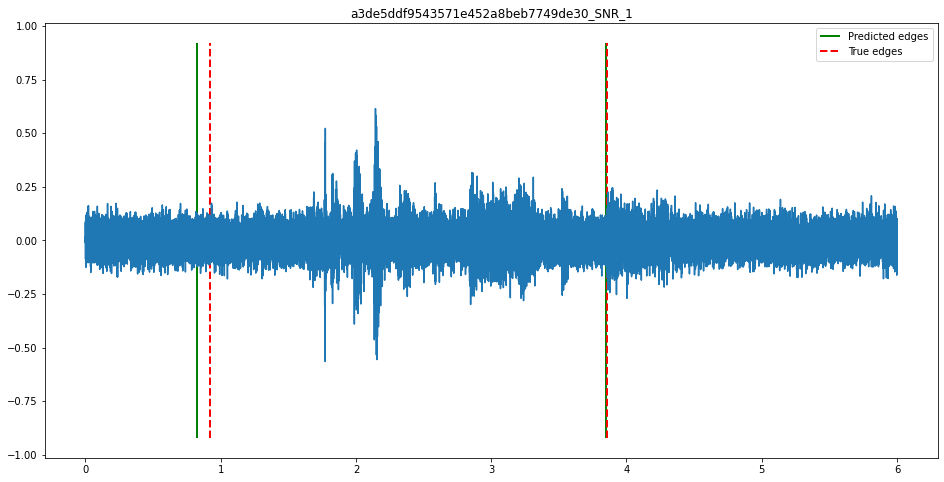

In [ ]:
num = randint(0, len(data_set_baseline['test']))
name, data, marks = data_set_baseline['test'][num]
model_baseline.eval()
pred = model_baseline(data.cuda().unsqueeze(0))
pred = torch.round(torch.sigmoid(pred))

sound_show(data, title=name, marks_true=marks, marks_pred=pred)

**MFCC**

In [39]:
model_feature = ConvConvT2D().cuda()
checkpoint = torch.load('/content/gdrive/MyDrive/7_0.149_2022-09-06_12-12-15')
model_feature.load_state_dict(checkpoint['model_state_dict'])

metrics_test_compute(model_feature, loaders_feature_map)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10377 [00:00<?, ?it/s]

{'Accuracy': 0.9527539169156145,
 'Precision': 0.9827302696404441,
 'Recall': 0.9200928427778517,
 'F1': 0.9483869423092429}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fa462919750>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


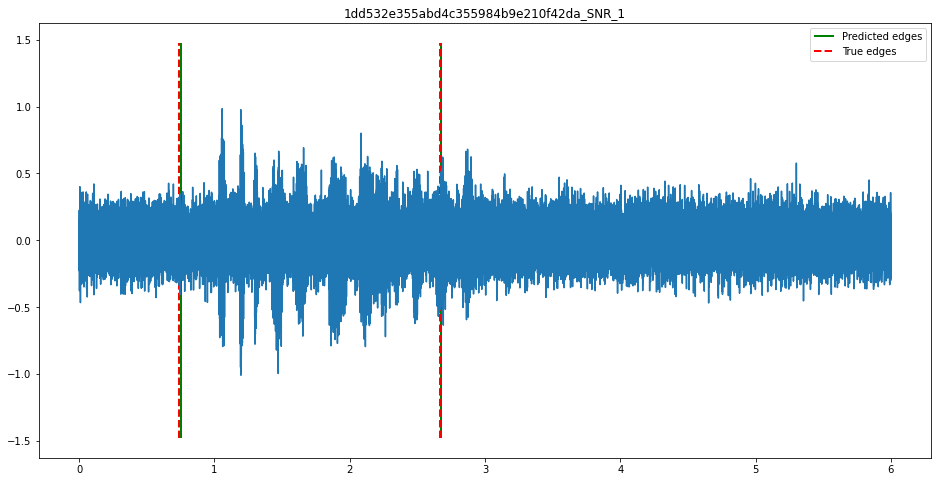

In [63]:
num = randint(0, len(data_set_feature_map['test']))
name, data, marks, signal = data_set_feature_map['test'][num]
model_feature.eval()
pred = model_feature(data.cuda().unsqueeze(0))
pred = torch.round(torch.sigmoid(pred))

sound_show(signal, title=name, marks_true=marks, marks_pred=pred)